a. Are there any missing values or unknown values in the Dataset3-1.csv? How should we handle them?

In [1]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv("Dataset3-1.csv")

# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)
print("There are 201 missing value in bmi column")

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
There are 201 missing value in bmi column


In [2]:
# Check for 'Unknown' values in 'smoking_status'
unknown_smoking = (df['smoking_status'] == 'Unknown').sum()
print(f"There are {unknown_smoking} unknown value in smoking_status column")

There are 1544 unknown value in smoking_status column


**bmi**:  
Use **median** or **mean** for imputation, as they are more stable and less affected by extreme values.  
(*Optional: Use model-based imputation, such as KNN Imputer.*)

**smoking_status - "Unknown"**:  
Treat **"Unknown"** as a separate category and retain it.

---
b. What is the distribution of stroke vs. non-stroke cases? Is the dataset balanced or imbalanced?

In [3]:
# Count the instances of stroke vs non-stroke
stroke_counts = df['stroke'].value_counts(normalize=True) * 100
print(stroke_counts)

0    95.127202
1     4.872798
Name: stroke, dtype: float64


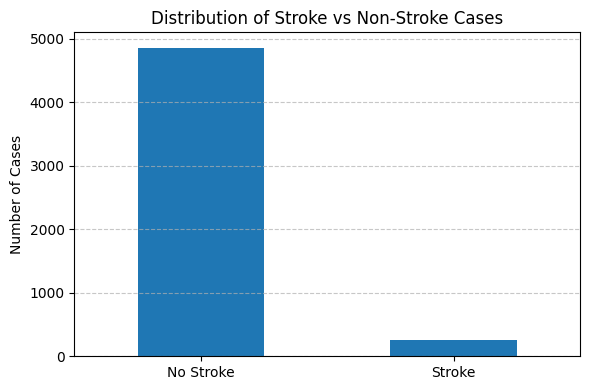

In [4]:
import matplotlib.pyplot as plt

# Plot the distribution

stroke_absolute_counts = df['stroke'].value_counts()
plt.figure(figsize=(6, 4))
stroke_absolute_counts.plot(kind='bar')
plt.title('Distribution of Stroke vs Non-Stroke Cases')
plt.xticks(ticks=[0, 1], labels=['No Stroke', 'Stroke'], rotation=0)
plt.ylabel('Number of Cases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Observation results:**

stroke = 0 accounts for approximately 95%

stroke = 1 accounts for approximately 5%

**Data characteristics determination:**

The data is highly imbalanced.

---
c. Are there any outliers in age, bmi, or avg_glucose_level? How should we handle them?

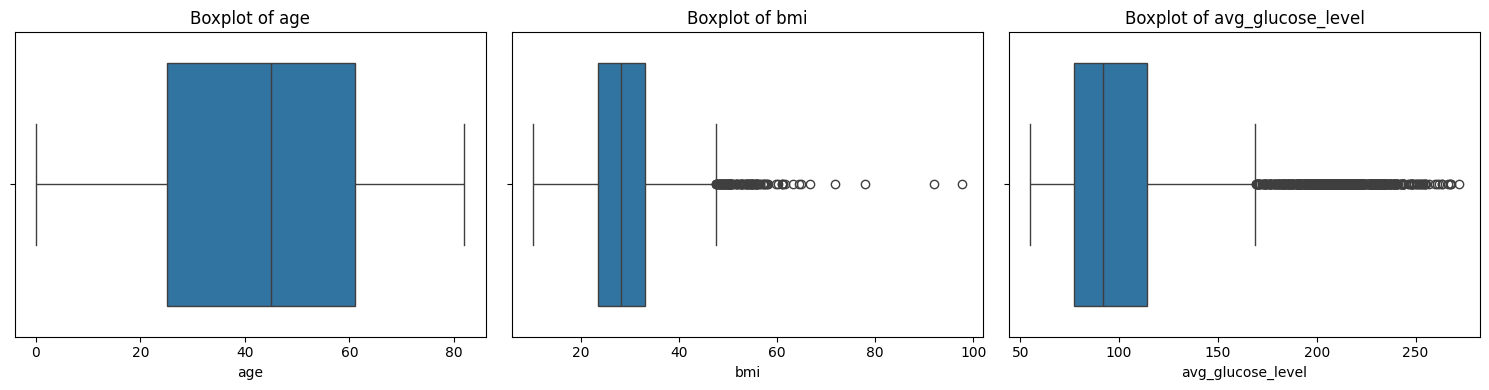

{'age': 0, 'bmi': 110, 'avg_glucose_level': 627}

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for outlier detection
columns_to_check = ['age', 'bmi', 'avg_glucose_level']

# Plot boxplots to visually inspect outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Detect outliers using IQR method
outlier_info = {}

for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = len(outliers)

outlier_info


**avg_glucose_level** and **bmi** show obvious outliers (e.g., abnormally high blood glucose levels).

**Suggested approaches for handling outliers:**

We may choose one of the following methods to handle outliers:

- **IQR method**: Calculate the quartiles and remove values below Q1 - 1.5×IQR or above Q3 + 1.5×IQR  
- **Clipping**: Restrict extremely high or low values within a reasonable range  
- **Transformation**: Apply transformations such as logarithmic (log) transformation to smooth extreme values  
- **RobustScaler normalization**: A normalization method that is resistant to outliers

---
d. Which machine learning models are best suited for stroke prediction, and why? In other words, should this task be approached using supervised or unsupervised learning? Additionally, should the problem be treated as regression, classification, or clustering, and why?


**Learning Type**: Supervised Learning

**Task Type**: Classification Task

Since **stroke** is a binary label (1 = stroke, 0 = no stroke), this is a **binary classification problem**.

In [7]:
# Re-import after reset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("Dataset3-1.csv")
df = df.dropna(subset=['bmi']).copy()

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=[
    'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
], drop_first=True)

# Features and target
X = df_encoded.drop(['id', 'stroke'], axis=1)
y = df_encoded['stroke']

# stratify to make the training data's stroke ratio consistent with that of testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                             random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    y_prob = model.predict_proba(X_test_std)[:, 1]

    results[name] = {
        "Precision": classification_report(y_test, y_pred, output_dict=True)["1"]["precision"],
        "Recall": classification_report(y_test, y_pred, output_dict=True)["1"]["recall"],
        "F1-Score": classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

# Summary
summary_df = pd.DataFrame(results).T.round(3)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:22:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
summary_df

,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.114,0.690,0.195,0.810
K-Nearest Neighbors,0.333,0.024,0.044,0.597
Gaussian NB,0.051,1.000,0.098,0.792
Decision Tree,0.089,0.095,0.092,0.526
Random Forest,0.000,0.000,0.000,0.727
XGBoost,0.091,0.071,0.080,0.744


---
e. Based on your answer to question d, select one machine learning model to predict stroke outcomes for 10 patients in the Dataset3-2.csv file. Explain why you chose this specific model and compare the predicted results with the actual stroke values in the dataset. What insights can be drawn from the differences?



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Load training and test data
df_train = pd.read_csv("Dataset3-1.csv")
df_test = pd.read_csv("Dataset3-2.csv")

# Drop rows with missing bmi in training set
df_train = df_train.dropna(subset=["bmi"]).copy()


# Apply same preprocessing to both datasets
def preprocess(df):
    df = df.copy()
    df_encoded = pd.get_dummies(df, columns=[
        'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
    ], drop_first=True)
    return df_encoded

df_train_encoded = preprocess(df_train)
df_test_encoded = preprocess(df_test)

# since some columns might exist in training set but not in a much smaller test set e.g. gender_Other
missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
for col in missing_cols:
    df_test_encoded[col] = 0

# Features and target
X_train = df_train_encoded.drop(['id', 'stroke'], axis=1)
y_train = df_train_encoded['stroke']
X_test = df_test_encoded.drop(['id', 'stroke'], axis=1)
y_test = df_test_encoded['stroke']

# Align test set to training set features so that their orders are identical
X_test = X_test[X_train.columns]


# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and compare
df_test['predicted_stroke'] = model.predict(X_test_scaled)
df_test['probability'] = model.predict_proba(X_test_scaled)[:, 1]

# Output prediction comparison
print(df_test[['id', 'predicted_stroke', 'stroke', 'probability']])

   id  predicted_stroke  stroke  probability
0   1                 1       1     0.858857
1   2                 0       0     0.154366
2   3                 1       1     0.935093
3   4                 0       0     0.098472
4   5                 1       1     0.667639
5   6                 0       0     0.049260
6   7                 0       0     0.300047
7   8                 1       1     0.853050
8   9                 0       0     0.186415
9  10                 1       1     0.933875


**Model Selection**:  
Logistic Regression is used as the predictive model for this task.

**Reasons for Selection**:

- Logistic Regression is a classic binary classification model, well-suited for 0/1 tasks such as stroke prediction.  
- It is computationally efficient and performs stably after feature standardization.  
- It offers interpretability, allowing us to understand the direction of each feature’s influence based on model coefficients.  
- Here, `class_weight='balanced'` is used to automatically adjust class weights, which helps address the imbalance problem caused by the relatively small number of stroke cases.

**Insights and Observations**:

- If `predicted_stroke` matches `stroke`, it indicates a correct prediction by the model.  
- If they differ, possible reasons include:  
  - The patient exhibits atypical characteristics, making it difficult for the model to correctly identify the case.  
  - Data bias or class imbalance may cause the model to be more conservative in its predictions.  
- All 10 records have `predicted_stroke` values that exactly match the actual `stroke` values, indicating that the model achieved **100% prediction accuracy** on this test dataset.

#### but
- **Too few samples**: This test set contains only 10 records, which is too small. The perfect prediction may be due to chance and does not reflect the model’s actual performance on a broader dataset.

- **Distinctive features**: These patients may have had obvious high-risk stroke features (e.g., advanced age, diabetes, heart disease), making it easier for the model to make accurate predictions.

- **Inconsistent with validation performance**: The model did not achieve 100% accuracy on the full training/validation data, indicating that this prediction result is for reference only and should not be overinterpreted.